In [1]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from uk_road_safety.python.data_cleaning import prepare_data_for_groupby, add_geohash
from uk_road_safety.python.grouped_data import data_for_analysis
from uk_road_safety.python import mlmodel
import tensorflow as tf

2022-12-12 17:11:45.883542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 17:11:46.496191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 17:11:46.496261: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-12 17:11:47.992262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/preprocessed-1999-2021.csv')

In [3]:
df_accidents['date']=pd.to_datetime(df_accidents['date'],format='%d/%m/%Y')

# Second Geohash gcpvhc

In [5]:
test_max_square=df_accidents[df_accidents['geohash']=='gcpvhc']
time_series_gcpvhc=data_for_analysis(test_max_square,'M')
time_series_gcpvhc.head(20)

,Accidents
date,
1999-01-31,12
1999-02-28,7
1999-03-31,6
1999-04-30,16
1999-05-31,10
1999-06-30,11
1999-07-31,14
1999-08-31,15
1999-09-30,11


In [6]:
FOLD_LENGTH=180 #each fold spans over 15 years
FOLD_STRIDE=12 #we have a fold every 1 year
INPUT_LENGTH=6 #every X_i sequence is 6 months
TRAIN_TEST_RATIO=.80 #in each fold, we use 3 years for training and 1 year for test
OUTPUT_LENGTH=6 #we want to predict the number of accidents in the next 6 months (y_i length)
SEQUENCE_STRIDE = 1

In [7]:
folds=mlmodel.get_folds(time_series_gcpvj0,FOLD_LENGTH,FOLD_STRIDE)
np.array(folds).shape

(8, 180, 1)

In [8]:
fold=folds[0]

In [9]:
fold

,Accidents
date,
1999-01-31,12
1999-02-28,7
1999-03-31,6
1999-04-30,16
1999-05-31,10
...,...
2013-08-31,9
2013-09-30,7
2013-10-31,11


In [10]:
(fold_train, fold_test) = mlmodel.train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)
fold_train.shape
columns=fold_train.columns

In [11]:
scaler=MinMaxScaler()
fold_train=pd.DataFrame(scaler.fit_transform(fold_train),columns=columns)
fold_test=pd.DataFrame(scaler.transform(fold_test),columns=columns)

In [12]:
X_train_scaled, y_train_scaled = mlmodel.get_X_y_strides(fold_train,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
X_test_scaled, y_test_scaled = mlmodel.get_X_y_strides(fold_test,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)

In [13]:
X_train_scaled.shape

(133, 6, 1)

In [14]:
y_train=y_train_scaled
y_test=y_test_scaled

In [15]:
y_train.shape

(133, 6, 1)

In [16]:
for i,y in enumerate(y_train_scaled):
    y_train[i]=(scaler.inverse_transform(y))
for i,y in enumerate(y_test_scaled):
    y_test[i]=(scaler.inverse_transform(y))

In [17]:
y_test=y_test.astype(int)
y_train=y_train.astype(int)

In [18]:
model = mlmodel.init_model(X_train_scaled)
model.summary()

2022-12-12 17:17:37.682069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-12 17:17:37.682297: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 17:17:37.682452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-12 17:17:37.682517: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-12 17:17:37.682573: W tensorf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 30)             3840      
                                                                 
 dense (Dense)               (None, 6, 20)             620       
                                                                 
 dropout (Dropout)           (None, 6, 20)             0         
                                                                 
 dense_1 (Dense)             (None, 6, 10)             210       
                                                                 
 dropout_1 (Dropout)         (None, 6, 10)             0         
                                                                 
 dense_2 (Dense)             (None, 6, 1)              11        
                                                                 
Total params: 4,681
Trainable params: 4,681
Non-trainabl

In [19]:
model, history = mlmodel.fit_model(model,X_train_scaled,y_train)

Epoch 1/500
6/6 [==============================] - 4s 136ms/step - loss: 92.2593 - mae: 8.9781 - val_loss: 38.5499 - val_mae: 5.7473
Epoch 2/500
6/6 [==============================] - 0s 23ms/step - loss: 91.2242 - mae: 8.9214 - val_loss: 38.0300 - val_mae: 5.7018
Epoch 3/500
6/6 [==============================] - 0s 21ms/step - loss: 90.2919 - mae: 8.8682 - val_loss: 37.3890 - val_mae: 5.6453
Epoch 4/500
6/6 [==============================] - 0s 18ms/step - loss: 88.9008 - mae: 8.7907 - val_loss: 36.5699 - val_mae: 5.5721
Epoch 5/500
6/6 [==============================] - 0s 20ms/step - loss: 87.1713 - mae: 8.6885 - val_loss: 35.5232 - val_mae: 5.4771
Epoch 6/500
6/6 [==============================] - 0s 22ms/step - loss: 85.1227 - mae: 8.5696 - val_loss: 34.1408 - val_mae: 5.3485
Epoch 7/500
6/6 [==============================] - 0s 21ms/step - loss: 82.6372 - mae: 8.4194 - val_loss: 32.2477 - val_mae: 5.1659
Epoch 8/500
6/6 [==============================] - 0s 21ms/step - loss: 78.

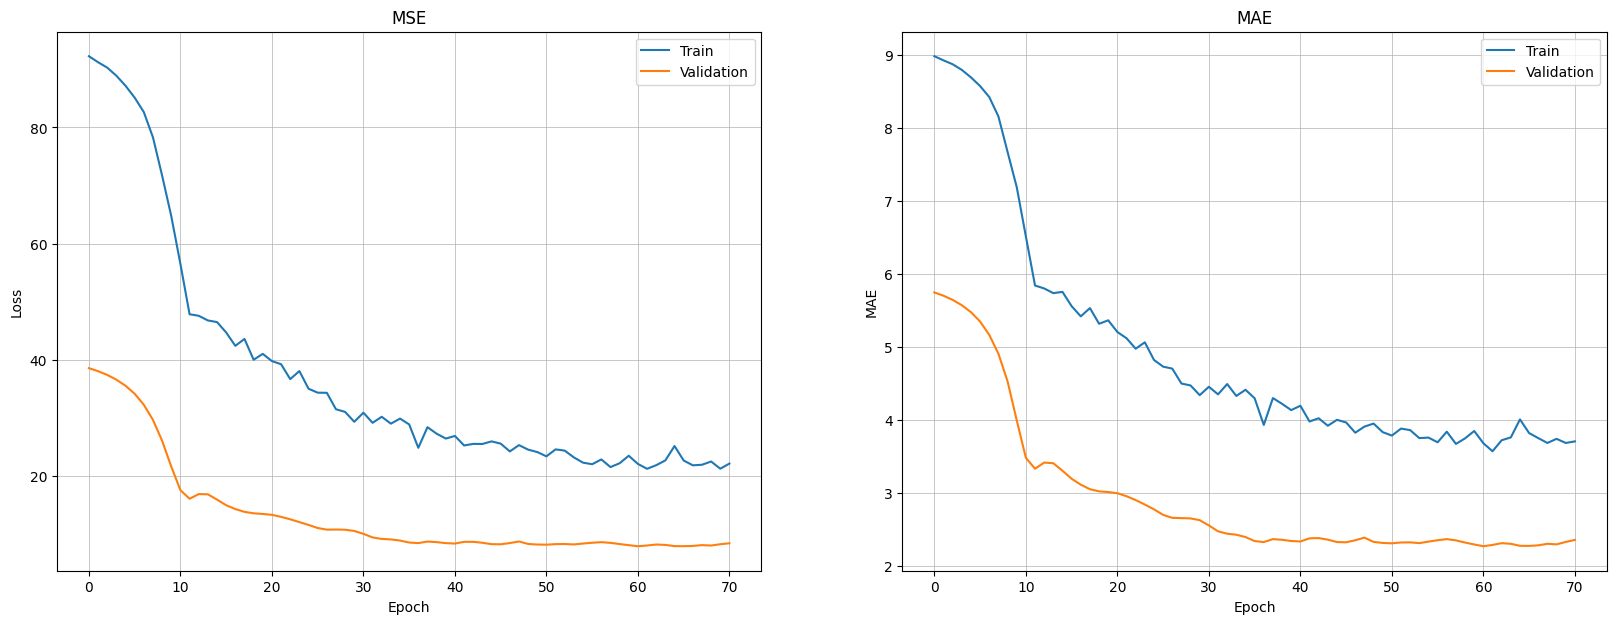

In [20]:
mlmodel.plot_history(history);

In [21]:
baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
baseline_score = baseline_model.evaluate(X_test_scaled, y_test_scaled)
res=model.evaluate(X_test_scaled,y_test_scaled)

1/1 [==============================] - 0s 355ms/step - loss: 10.4350 - mae: 2.5953


In [22]:
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} accidents")
print(f"Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} %")

The LSTM MAE on the test set is equal to 2.6 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = : 59.21 %


In [23]:
mae_baselines, mae_lstms = mlmodel.cross_validate_baseline_and_lstm(time_series_gcpvhc,FOLD_LENGTH, FOLD_STRIDE,
                                     TRAIN_TEST_RATIO, INPUT_LENGTH,
                                     OUTPUT_LENGTH, SEQUENCE_STRIDE)

8
--------------------------------------------------
MAE baseline fold n°0 = 6.35
MAE LSTM fold n°0 = 3.71
Improvement over baseline: 41.59 % 

--------------------------------------------------
MAE baseline fold n°1 = 6.22
MAE LSTM fold n°1 = 3.47
Improvement over baseline: 44.16 % 

--------------------------------------------------
MAE baseline fold n°2 = 6.1
MAE LSTM fold n°2 = 2.99
Improvement over baseline: 50.96 % 

--------------------------------------------------
MAE baseline fold n°3 = 5.29
MAE LSTM fold n°3 = 2.66
Improvement over baseline: 49.7 % 

--------------------------------------------------
MAE baseline fold n°4 = 6.02
MAE LSTM fold n°4 = 2.79
Improvement over baseline: 53.64 % 

--------------------------------------------------
MAE baseline fold n°5 = 6.01
MAE LSTM fold n°5 = 3.03
Improvement over baseline: 49.5 % 

--------------------------------------------------
MAE baseline fold n°6 = 5.68
MAE LSTM fold n°6 = 2.89
Improvement over baseline: 49.14 % 

-------

In [24]:
print(f"➡ Average percentage improvement over baseline = {round(np.mean(1 - np.array(mae_lstms)/np.array(mae_baselines)),2)*100}%")

➡ Average percentage improvement over baseline = 48.0%


1/1 [==============================] - 0s 46ms/step


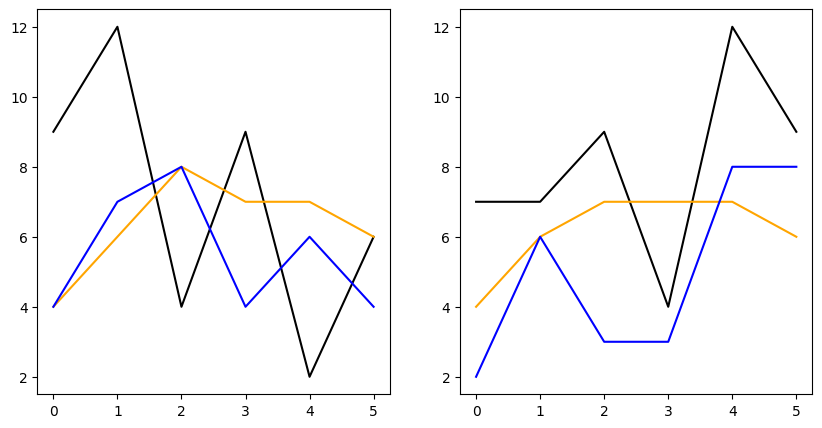

In [25]:
y_pred=model.predict(X_test_scaled)
y_bas_pred=[scaler.inverse_transform(y) for y in baseline_model.predict(X_test_scaled)]
mlmodel.plot_predictions(y_test, y_pred, y_bas_pred)

In [26]:
(train_final, test_final) = mlmodel.train_test_split(time_series_gcpvj0, TRAIN_TEST_RATIO, INPUT_LENGTH)
columns=train_final.columns
scaler=MinMaxScaler()
train_final=pd.DataFrame(scaler.fit_transform(train_final),columns=columns)
test_final=pd.DataFrame(scaler.transform(test_final),columns=columns)
X_train_final, y_train_final_s = mlmodel.get_X_y_strides(train_final,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
X_test_final, y_test_final_s = mlmodel.get_X_y_strides(test_final,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
y_train_final=y_train_final_s
y_test_final=y_test_final_s
for i,y in enumerate(y_train_final_s):
    y_train_final[i]=(scaler.inverse_transform(y))
for i,y in enumerate(y_test_final_s):
    y_test_final[i]=(scaler.inverse_transform(y))
y_test_final=y_test_final.astype(int)
y_train_final=y_train_final.astype(int)


In [27]:
model = mlmodel.init_model(X_train_final)
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 6, 30)             3840      
                                                                 
 dense_27 (Dense)            (None, 6, 20)             620       
                                                                 
 dropout_18 (Dropout)        (None, 6, 20)             0         
                                                                 
 dense_28 (Dense)            (None, 6, 10)             210       
                                                                 
 dropout_19 (Dropout)        (None, 6, 10)             0         
                                                                 
 dense_29 (Dense)            (None, 6, 1)              11        
                                                                 
Total params: 4,681
Trainable params: 4,681
Non-train

In [28]:
model, history = mlmodel.fit_model(model,X_train_final,y_train_final)

Epoch 1/500
10/10 [==============================] - 4s 57ms/step - loss: 74.2394 - mae: 7.8038 - val_loss: 47.2536 - val_mae: 6.1987
Epoch 2/500
10/10 [==============================] - 0s 15ms/step - loss: 73.1749 - mae: 7.7363 - val_loss: 46.3931 - val_mae: 6.1305
Epoch 3/500
10/10 [==============================] - 0s 15ms/step - loss: 71.8234 - mae: 7.6503 - val_loss: 45.2833 - val_mae: 6.0415
Epoch 4/500
10/10 [==============================] - 0s 15ms/step - loss: 70.2957 - mae: 7.5409 - val_loss: 43.5441 - val_mae: 5.8987
Epoch 5/500
10/10 [==============================] - 0s 16ms/step - loss: 67.3124 - mae: 7.3359 - val_loss: 40.5594 - val_mae: 5.6429
Epoch 6/500
10/10 [==============================] - 0s 17ms/step - loss: 62.1384 - mae: 6.9561 - val_loss: 35.3420 - val_mae: 5.1608
Epoch 7/500
10/10 [==============================] - 0s 17ms/step - loss: 54.0912 - mae: 6.3400 - val_loss: 27.5364 - val_mae: 4.3797
Epoch 8/500
10/10 [==============================] - 0s 17ms/s

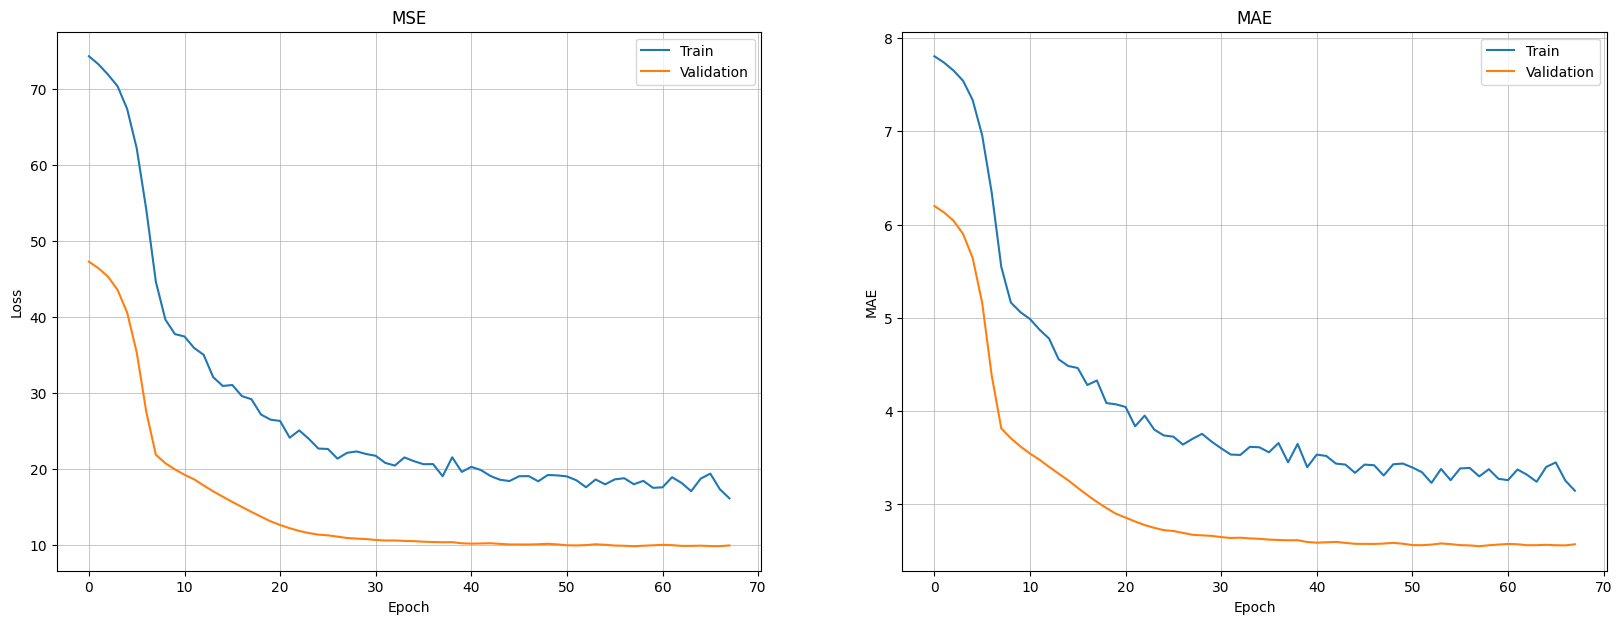

In [29]:
mlmodel.plot_history(history);

In [30]:
baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
baseline_score = baseline_model.evaluate(X_test_final, y_test_final_s)
res=model.evaluate(X_test_final,y_test_final)
res

2/2 [==============================] - 0s 9ms/step - loss: 11.1818 - mae: 2.8117


[11.18179702758789, 2.8117456436157227]

2/2 [==============================] - 0s 4ms/step


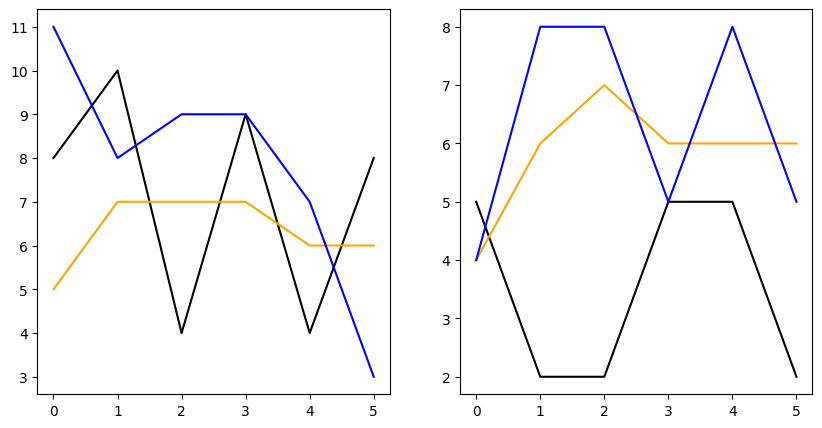

In [31]:
y_pred_final=model.predict(X_test_final)
y_bas_pred_final=[scaler.inverse_transform(y) for y in baseline_model.predict(X_test_final)]
mlmodel.plot_predictions(y_test_final, y_pred_final, y_bas_pred_final)

In [32]:
X_end_2021_final=scaler.transform(time_series_gcpvhc.tail(6))
y_2022_final=model.predict([X_end_2021_final]).astype(int)
y_2022_final

1/1 [==============================] - 0s 326ms/step


array([[[4]],

       [[5]],

       [[4]],

       [[5]],

       [[4]],

       [[4]]])

In [33]:
model.save(f'../model/gcpvhc')
np.save(os.path.join('../data',f'X_gcpvhc.npy'), X_end_2021_final)

INFO:tensorflow:Assets written to: ../model/gcpvhc/assets


INFO:tensorflow:Assets written to: ../model/gcpvhc/assets
